<h1 align="center">Deep Learning</h1>
<h4 align="center">Dr. Fatemi Zadeh</h4>
<h4 align="center">Sharif University of Technology, Fall 2024</h4>
<h4 align="center">Final Project - Phase 2 </h4>



**Student Name**: Radin Khayyam

**Student ID**: 99101579

---

---
# Question 1: Prepare and Pre-Process The Dataset
---

### **Download the dataset:**

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayushspai/sportsmot")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


### **Import necessary libraries:**

In [ ]:
!pip install ultralytics
!pip install deep_sort_realtime
!pip install motmetrics

In [73]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import functional as F
from torchvision.transforms.functional import adjust_brightness, adjust_contrast
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.optim as optim
from tqdm import tqdm
from ultralytics import YOLO
import shutil
import yaml
import random
from collections import defaultdict
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import Video, display
import motmetrics as mm

### **DatasetGenerator Class (Custom Dataset for SportsMOT)**
   - **Initialization (`__init__`)**:
     - The `DatasetGenerator` class is built to load and process data from the **SportsMOT** dataset. You provide the root directory where the dataset is stored (`dataset_root_dir`).
     - You can also choose whether to apply data augmentation (like flipping or adjusting brightness) and set the probability of applying it.
     - The code looks for all the sequences (video clips) in the dataset directory, and for each sequence, it loads the metadata from a `gt.txt` file. This file contains information about player positions (like their bounding boxes and IDs).
     - Only the annotations for players (class `1`) are kept, and the images are sorted and stored by frame number.
     - A random decision is made for each sequence whether to apply data augmentation, and if so, it chooses between flipping the image or adjusting the brightness.

   - **Data Sample Collection**:
     - For each frame in a sequence, the corresponding image and annotations are stored. The annotations contain details about the players, like their IDs and bounding boxes, and the frame number.

### **Data Augmentation in `__getitem__`**:
   - **Applying Augmentation**: 
     - If augmentation is enabled, it applies a random transformation to the image based on the sequence's metadata.
     - If the image is flipped, the bounding box coordinates are adjusted to reflect the flip. If brightness adjustment is selected, the brightness of the image is changed depending on the frame number.
   
   - **Returning the Sample**:
     - After the image has been processed, it's transformed (resized and normalized).
     - The function returns both the image and the annotations, which include:
       - Bounding boxes for the players.
       - Player IDs.
       - The area of each bounding box (width × height).
       - An "iscrowd" label (which is zero in this case, since we’re dealing with individual players, not crowds).

In [20]:
class DatasetGenerator(Dataset):
    """
    Custom Dataset for loading and preprocessing the SportsMOT dataset.
    """
    def __init__(self, dataset_root_dir, transform=None, apply_augmentation=True, augmentation_probability=0.5):
        """
        Args:
            dataset_root_dir (str): Directory with the dataset sequences.
            transform (callable, optional): Transformation pipeline for the images.
            apply_augmentation (bool): Flag indicating whether to apply data augmentation.
            augmentation_probability (float): Probability of applying augmentation to each sequence.
        """
        self.dataset_root_dir = dataset_root_dir
        self.transform = transform
        self.apply_augmentation = apply_augmentation
        self.augmentation_probability = augmentation_probability
        self.sequence_names = [
            sequence for sequence in os.listdir(dataset_root_dir)
            if os.path.isdir(os.path.join(dataset_root_dir, sequence))
        ]
        self.data_samples = []
        self.sequence_metadata = {}  # Store metadata for each sequence

        # Loop through each sequence to load the data and annotations
        for sequence_name in self.sequence_names:
            sequence_path = os.path.join(dataset_root_dir, sequence_name)
            image_directory = os.path.join(sequence_path, "img1")
            ground_truth_file = os.path.join(sequence_path, "gt", "gt.txt")
            
            try:
                # Load the annotations from the ground truth file
                annotations_df = pd.read_csv(
                    ground_truth_file, header=None,
                    names=['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'cls', 'vis']
                )
                annotations_df = annotations_df[annotations_df['cls'] == 1]  # Filter for player annotations
            except FileNotFoundError:
                print(f"Error: Ground truth file not found for sequence: {sequence_name}")
                continue

            image_files = sorted([
                file for file in os.listdir(image_directory)
                if file.endswith('.jpg') and file.split('.')[0].isdigit()
            ])

            # Determine whether to apply augmentation for the sequence
            apply_augmentation_to_sequence = np.random.rand() < self.augmentation_probability
            if apply_augmentation_to_sequence:
                augmentation_type = np.random.choice(["flip", "brightness"])
            else:
                augmentation_type = None

            # Store augmentation type and metadata for the sequence
            self.sequence_metadata[sequence_name] = {
                "augmentation_type": augmentation_type,
                "brightness_range": (5, 25) if augmentation_type == "brightness" else None,
                "max_brightness_factor": 1.5,
                "min_brightness_factor": 0.7
            }

            # Collect samples for each frame in the sequence
            for image_file in image_files:
                frame_number = int(image_file.split('.')[0])
                frame_annotations = annotations_df[annotations_df['frame'] == frame_number]
                self.data_samples.append({
                    'image_path': os.path.join(image_directory, image_file),
                    'annotations': frame_annotations,
                    'sequence_name': sequence_name,
                    'frame_number': frame_number
                })

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.data_samples)

    def __getitem__(self, idx):
        """
        Returns a sample of data (image and its annotations) by index.
        """
        sample = self.data_samples[idx]
        image = cv2.imread(sample['image_path'])
        if image is None:
            raise ValueError(f"Failed to load image: {sample['image_path']}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
        # Extract bounding boxes and player IDs from the annotations
        annotations = sample['annotations']
        bounding_boxes = annotations[['x', 'y', 'w', 'h']].values.astype(float)
        player_ids = annotations['id'].values.astype(int)
    
        bounding_boxes[:, 2:] += bounding_boxes[:, :2]  # Convert (x, y, w, h) → (x1, y1, x2, y2)
        original_height, original_width, _ = image.shape
    
        # Convert the image to a PIL Image format for transformations
        pil_image = transforms.ToPILImage()(image)
    
        # Apply augmentations if enabled
        if self.apply_augmentation:
            sequence_metadata = self.sequence_metadata[sample['sequence_name']]
            augmentation_type = sequence_metadata["augmentation_type"]
    
            if augmentation_type == "flip":
                pil_image = F.hflip(pil_image)
                # Adjust bounding boxes for horizontal flip
                bounding_boxes[:, [0, 2]] = original_width - bounding_boxes[:, [2, 0]]
    
            elif augmentation_type == "brightness":
                frame_number = sample['frame_number']
                brightness_range = sequence_metadata["brightness_range"]
    
                if brightness_range and brightness_range[0] <= frame_number <= brightness_range[1]:
                    midpoint = sum(brightness_range) / 2
                    if frame_number < midpoint:
                        brightness_factor = np.interp(frame_number, [brightness_range[0], midpoint],
                                                     [1.0, sequence_metadata["max_brightness_factor"]])
                    else:
                        brightness_factor = np.interp(frame_number, [midpoint, brightness_range[1]],
                                                     [sequence_metadata["max_brightness_factor"], sequence_metadata["min_brightness_factor"]])
                    
                    pil_image = adjust_brightness(pil_image, brightness_factor)
                    pil_image = adjust_contrast(pil_image, brightness_factor)
    
        # Apply the transformation pipeline (if provided)
        if self.transform:
            transformed_image = self.transform(pil_image)  # Transform to tensor format
        else:
            transformed_image = transforms.ToTensor()(pil_image)
    
        # Convert bounding boxes to tensor
        bounding_boxes_tensor = torch.as_tensor(bounding_boxes, dtype=torch.float32)
        labels_tensor = torch.ones((len(annotations),), dtype=torch.int64)  # Assuming one class: players
    
        return transformed_image, {
            'boxes': bounding_boxes_tensor,
            'labels': labels_tensor,
            'player_ids': torch.as_tensor(player_ids, dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'area': (bounding_boxes_tensor[:, 3] - bounding_boxes_tensor[:, 1]) * (bounding_boxes_tensor[:, 2] - bounding_boxes_tensor[:, 0]),
            'iscrowd': torch.zeros((len(annotations),), dtype=torch.int64)
        }


### **Transformations (`train_transform` and `val_transform`)**:
   - The `train_transform` and `val_transform` pipelines define how the images are resized and normalized:
     - Both the training and validation images are resized to 720x1280 pixels.
     - Then, they are normalized using standard mean and standard deviation values, which helps the model train more effectively.
     - These transformations are the same for both training and validation, but note that augmentation is only applied during training.

In [21]:
train_transform = transforms.Compose([
    transforms.Resize((720, 1280)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((720, 1280)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = "/kaggle/input/sportsmot_publish/dataset/train"
val_dir = "/kaggle/input/sportsmot_publish/dataset/val"

train_dataset = DatasetGenerator(train_dir, transform=train_transform, apply_augmentation=True)
val_dataset = DatasetGenerator(val_dir, transform=train_transform, apply_augmentation=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 28574
Validation samples: 26970


### **Setting Up the DataLoader**:
   - **`train_loader` and `val_loader`**:
     - The dataset is wrapped into a `DataLoader` so it can be efficiently loaded in batches. This makes it easier to train your model with multiple images at once.
     - The batch size is set to 8, and the number of workers (threads) for loading the data is set to 2.
     - The `collate_fn` ensures the images and their annotations are grouped correctly into batches.

In [22]:
BATCH_SIZE = 8
NUM_WORKERS = 2  

train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,  
    num_workers = NUM_WORKERS,
    collate_fn = lambda x: tuple(zip(*x))
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False, 
    num_workers = NUM_WORKERS,
    collate_fn = lambda x: tuple(zip(*x))
)

for images, targets in train_loader:
    print(f"Batch size: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Target keys: {targets[0].keys()}")
    break

Batch size: 8
Image shape: torch.Size([3, 720, 1280])
Target keys: dict_keys(['boxes', 'labels', 'player_ids', 'image_id', 'area', 'iscrowd'])


### **Visualizing the Data**:
   - The `visualize_images_with_annotations` function is used to visualize a batch of images along with their annotations:
     - It takes the images from the batch, undoes the normalization (so they can be displayed properly), and then shows them.
     - For each image, it draws bounding boxes around the players, and labels them with their IDs.
     - This function helps you check whether the bounding boxes and player IDs are being processed correctly.

Visualizing Batch 1:


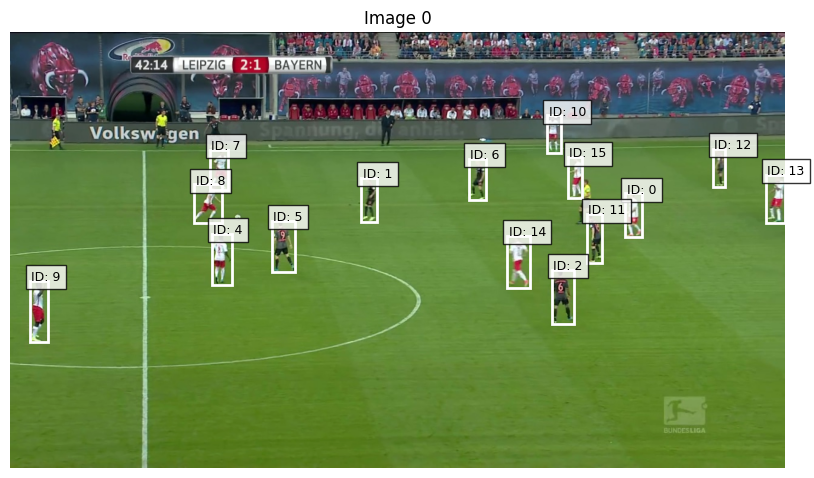

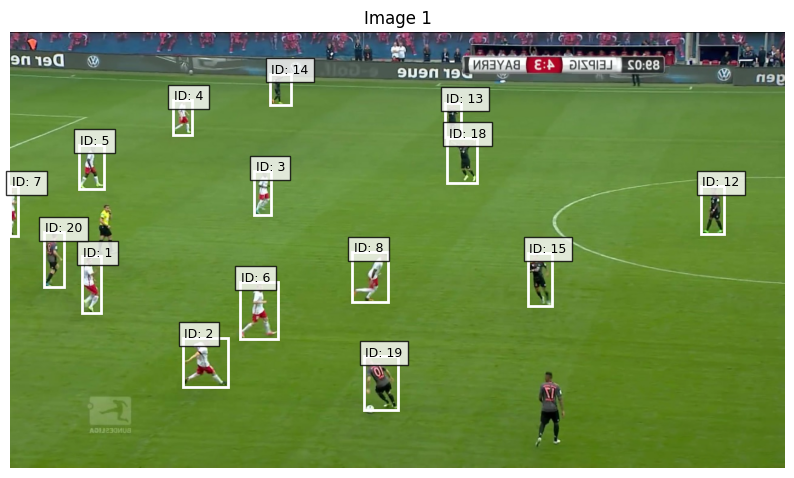

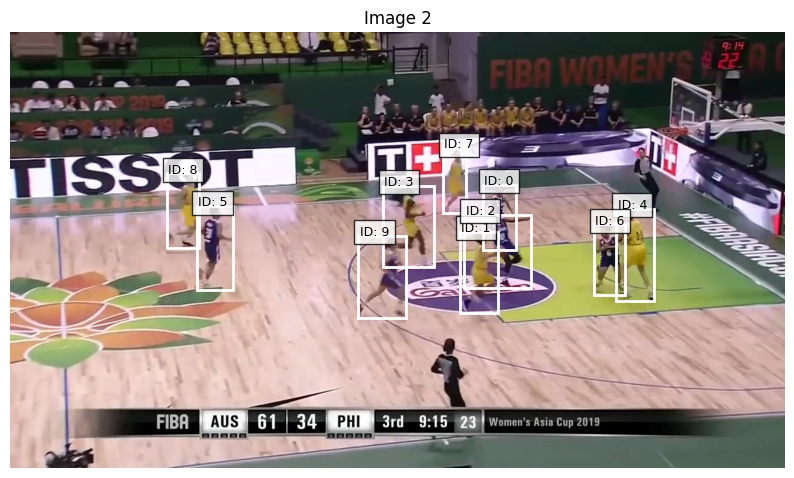

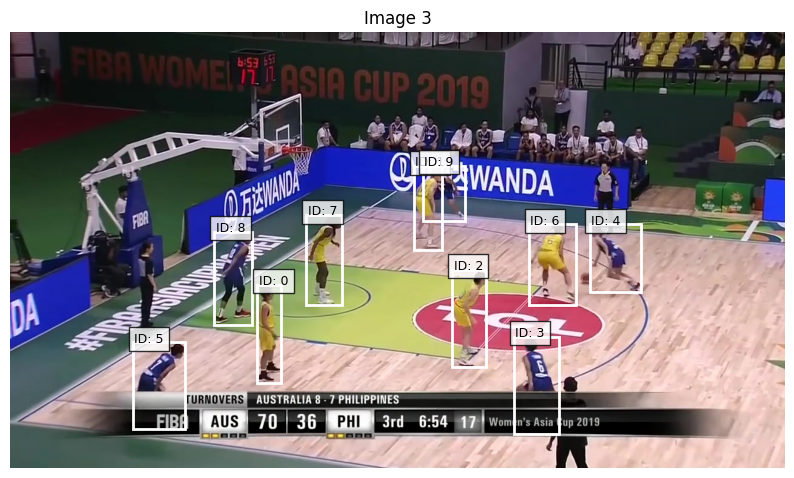

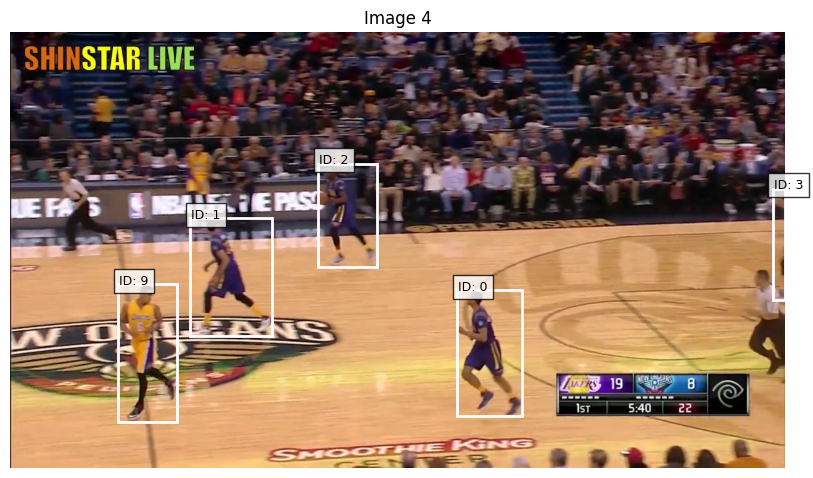

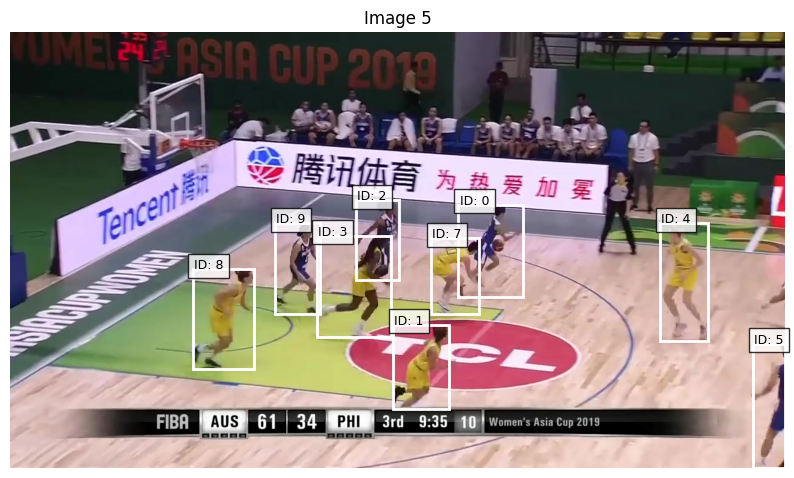

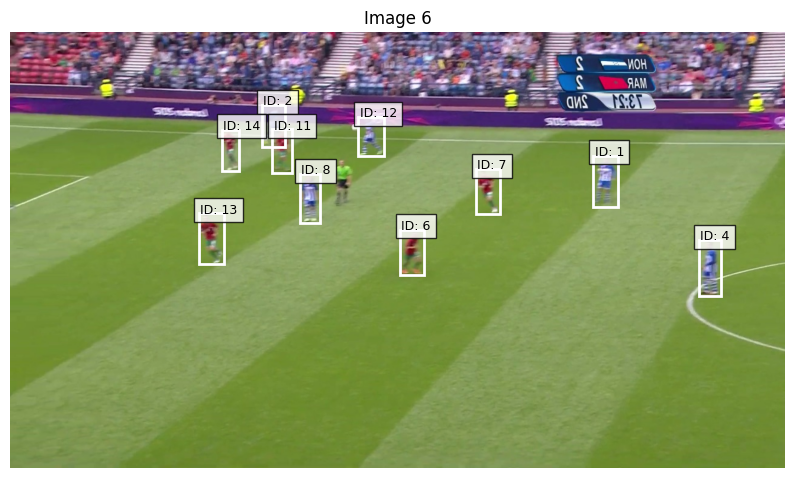

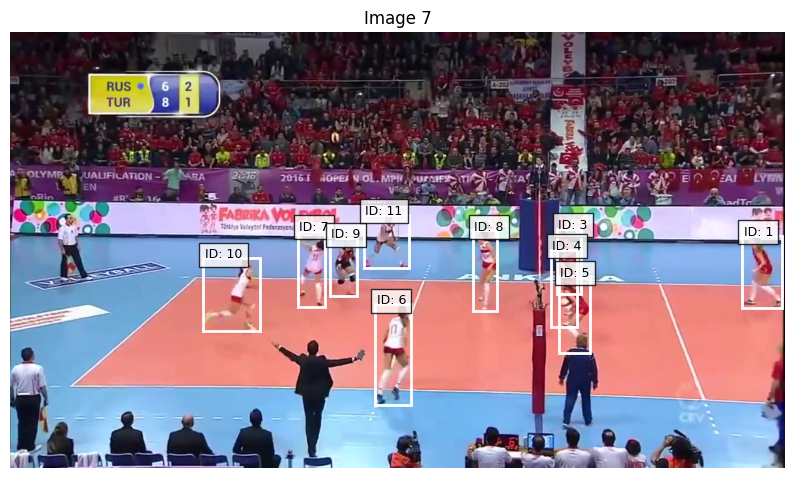

In [23]:
def visualize_images_with_annotations(images, targets, image_offset=0):
    """
    Visualizes a batch of images with their bounding boxes and player IDs.
    
    Args:
        images (torch.Tensor): Batch of images (Tensor format).
        targets (list): List of dictionaries containing annotations (boxes, labels, player_ids).
        image_offset (int): An offset value for image indexing in batch visualization.
    """
    for idx, (image, target) in enumerate(zip(images, targets)):
        img_array = image.permute(1, 2, 0).numpy()  
        img_array = img_array * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Normalize back
        img_array = (img_array * 255).astype('uint8')  # Convert to 8-bit integer
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.imshow(img_array)
        ax.set_title(f"Image {idx + image_offset}")

        # Retrieve bounding boxes and player IDs
        boxes = target['boxes'].cpu().numpy()
        player_ids = target.get('player_ids', torch.tensor([])).cpu().numpy()
        
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='white', facecolor='none')
            ax.add_patch(rect)
            if len(player_ids) > i:
                player_id = player_ids[i]
                ax.text(x1 + 2, y1, f"ID: {player_id}", color='black', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.axis('off')
        plt.show()

# Example usage with a DataLoader
for batch_idx, (batch_images, batch_targets) in enumerate(train_loader):
    print(f"Visualizing Batch {batch_idx + 1}:")
    visualize_images_with_annotations(batch_images, batch_targets, image_offset=batch_idx * len(batch_images))
    if batch_idx > -1:
        break

---
# Question 2.1: Object Tracking
---

## **1-** 
We chose **YOLO (You Only Look Once)** for our object detection task in sports videos for several key reasons:

1. **Real-Time Performance**:
   YOLO is known for its **exceptionally fast processing speed**, which makes it ideal for real-time object detection. Sports videos often involve fast-moving players and frequent changes in the scene, so we need a method that can handle these dynamic conditions quickly. YOLO detects objects in a single pass through the network, making it capable of processing video frames efficiently, which is crucial for real-time tracking.

2. **Single Unified Architecture**:
   Unlike other object detection methods that use multiple stages (such as region proposal networks and classification), YOLO treats object detection as a **single regression problem**. This unified approach allows YOLO to simultaneously predict both the bounding boxes and the class labels in one step. This simplicity not only boosts the speed but also helps maintain high accuracy in detecting objects in sports videos.

3. **High Accuracy in Crowded Scenes**:
   Sports videos often feature many players in close proximity, with frequent overlaps. YOLO is well-suited for handling these **crowded scenes** because it can detect multiple objects (players) within a single frame without confusion. Its ability to predict bounding boxes and classify objects at the same time allows it to effectively track players in complex situations, even when they are close to each other.

4. **Small Object Detection**:
   Players in sports videos can sometimes appear small in the frame, especially when they are far from the camera. YOLO is particularly good at detecting **small objects**. The latest versions of YOLO (like YOLOv4 or YOLOv5) have improved mechanisms for detecting small objects by enhancing the resolution of feature maps, ensuring that players even in the background are accurately detected.

5. **Scalability**:
   YOLO can be trained to detect various object types, making it **flexible** enough for sports applications where different classes of objects (e.g., players, balls, goals) may need to be tracked. This versatility is valuable for tracking players and possibly other objects, such as the ball, in sports videos.

6. **Proven Success in Object Detection**:
   YOLO has become one of the most widely used methods in object detection tasks across a variety of domains, from autonomous driving to surveillance. Its proven track record in real-world applications gives us confidence in its ability to perform well on sports video data.

## **2-**

In [41]:
def save_annotations_to_yolo_format(dataset, output_dir, device='cpu'):
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if dataset is a subset or not
    if isinstance(dataset, Subset):
        original_dataset = dataset.dataset
        indices = dataset.indices
    else:
        original_dataset = dataset
        indices = range(len(dataset))
    
    # Using tqdm to show the progress of the loop
    for idx in tqdm(indices, desc="Saving annotations", unit="image"):
        image_path = original_dataset.data_samples[idx]['image_path']
        _, target = original_dataset[idx]
        img_name = os.path.basename(image_path).replace('.jpg', '.txt')
        
        img_width, img_height = Image.open(image_path).size
        
        annotations = target['boxes'].to(device)
        labels = target['labels'].to(device) 

        yolo_lines = []
        for box in annotations:
            x_min, y_min, x_max, y_max = box
            x_center = ((x_min + x_max) / 2) / img_width
            y_center = ((y_min + y_max) / 2) / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height
            
            yolo_lines.append(f"0 {x_center.item()} {y_center.item()} {width.item()} {height.item()}")  # Convert tensor to Python scalars
        
        annotation_path = os.path.join(output_dir, img_name)
        with open(annotation_path, 'w') as f:
            f.write('\n'.join(yolo_lines))

# Set device to CUDA or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_image_output = "/kaggle/working/train/images"
val_image_output = "/kaggle/working/val/images"
train_label_output = "/kaggle/working/train/labels"
val_label_output = "/kaggle/working/val/labels"

os.makedirs(train_image_output, exist_ok=True)
os.makedirs(val_image_output, exist_ok=True)

# Saving annotations with progress bars
save_annotations_to_yolo_format(train_dataset, train_label_output, device=device)
save_annotations_to_yolo_format(val_dataset, val_label_output, device=device)

# Progress bar for copying images
for sample in tqdm(train_dataset.data_samples, desc="Copying train images", unit="image"):
    shutil.copy(sample['image_path'], train_image_output)
    
for sample in tqdm(val_dataset.data_samples, desc="Copying val images", unit="image"):
    shutil.copy(sample['image_path'], val_image_output)

Copying val images: 100%|██████████| 26970/26970 [00:40<00:00, 663.35image/s]


In [44]:
Sportsmot_Yaml = {
    'train': '/kaggle/working/train/images',
    'val': '/kaggle/working/val/images',
    'nc': 1,  
    'names': ['player']  
}

with open('/kaggle/working/SportsMOT_dataset.yaml', 'w') as file:
    yaml.dump(Sportsmot_Yaml, file)

print("YAML file created successfully!")

detection_model = YOLO("yolov8n.pt")

results = detection_model.train(
    data = "/kaggle/working/SportsMOT_dataset.yaml",
    epochs = 20,
    batch = 8,
    imgsz = 640,
    device = "cuda",
    pretrained=True 
)

YAML file created successfully!
Ultralytics 8.3.71 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/SportsMOT_dataset.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

train: Scanning /kaggle/working/train/labels.cache... 1825 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1825/1825 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.8G       1.58      1.529      1.252         36        640: 100%|██████████| 229/229 [00:25<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:09<00:00,  7.98it/s]


                   all       1215      11723      0.869      0.801      0.874      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.47G       1.42      1.113      1.164         11        640: 100%|██████████| 229/229 [00:24<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00,  9.73it/s]


                   all       1215      11723      0.892      0.793      0.896      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.49G      1.351      1.025      1.132         21        640: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00,  9.98it/s]


                   all       1215      11723      0.845      0.757       0.86      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.61G      1.319     0.9705      1.118         10        640: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00,  9.96it/s]


                   all       1215      11723      0.843      0.802      0.863      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.54G      1.274     0.9363      1.097          5        640: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.10it/s]


                   all       1215      11723        0.8      0.688      0.767      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.49G      1.215     0.8746      1.073         11        640: 100%|██████████| 229/229 [00:23<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.38it/s]

                   all       1215      11723      0.816        0.7        0.8       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.52G      1.163     0.8362      1.054         15        640: 100%|██████████| 229/229 [00:23<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.23it/s]

                   all       1215      11723      0.846      0.749      0.846      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.54G      1.168     0.8408      1.053          5        640: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.45it/s]

                   all       1215      11723      0.907      0.803      0.896      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.54G      1.136     0.8156      1.041         26        640: 100%|██████████| 229/229 [00:23<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.81it/s]


                   all       1215      11723      0.831      0.746      0.832      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.53G      1.106     0.7813      1.028         19        640: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.47it/s]


                   all       1215      11723      0.848      0.737      0.847      0.597
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.42G      1.074     0.7885      1.022         10        640: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.42it/s]

                   all       1215      11723      0.793       0.64      0.744      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.37G      1.048     0.7672      1.012          8        640: 100%|██████████| 229/229 [00:22<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.57it/s]

                   all       1215      11723      0.857      0.574      0.702       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.37G      1.037     0.7564      1.008          7        640: 100%|██████████| 229/229 [00:23<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.16it/s]


                   all       1215      11723      0.847      0.796      0.869      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.42G     0.9942     0.7275     0.9881          6        640: 100%|██████████| 229/229 [00:22<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.56it/s]

                   all       1215      11723      0.828      0.711      0.799      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.37G     0.9915      0.725     0.9848         11        640: 100%|██████████| 229/229 [00:22<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.55it/s]


                   all       1215      11723      0.848      0.653      0.776      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.37G     0.9626     0.7018     0.9718         12        640: 100%|██████████| 229/229 [00:22<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.51it/s]

                   all       1215      11723      0.856      0.655      0.761      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.37G     0.9371     0.6834     0.9608         10        640: 100%|██████████| 229/229 [00:22<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.51it/s]

                   all       1215      11723      0.828      0.695      0.773      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.37G       0.92     0.6804     0.9575          9        640: 100%|██████████| 229/229 [00:23<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.54it/s]

                   all       1215      11723      0.835      0.756      0.824      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.42G     0.8984     0.6586     0.9483          8        640: 100%|██████████| 229/229 [00:22<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.42it/s]

                   all       1215      11723      0.819      0.651      0.727      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.37G     0.8828     0.6558     0.9456         12        640: 100%|██████████| 229/229 [00:23<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:07<00:00, 10.43it/s]

                   all       1215      11723      0.822      0.704      0.772      0.486



20 epochs completed in 0.181 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.71 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:09<00:00,  7.65it/s]


                   all       1215      11723      0.906      0.804      0.896      0.621


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train3


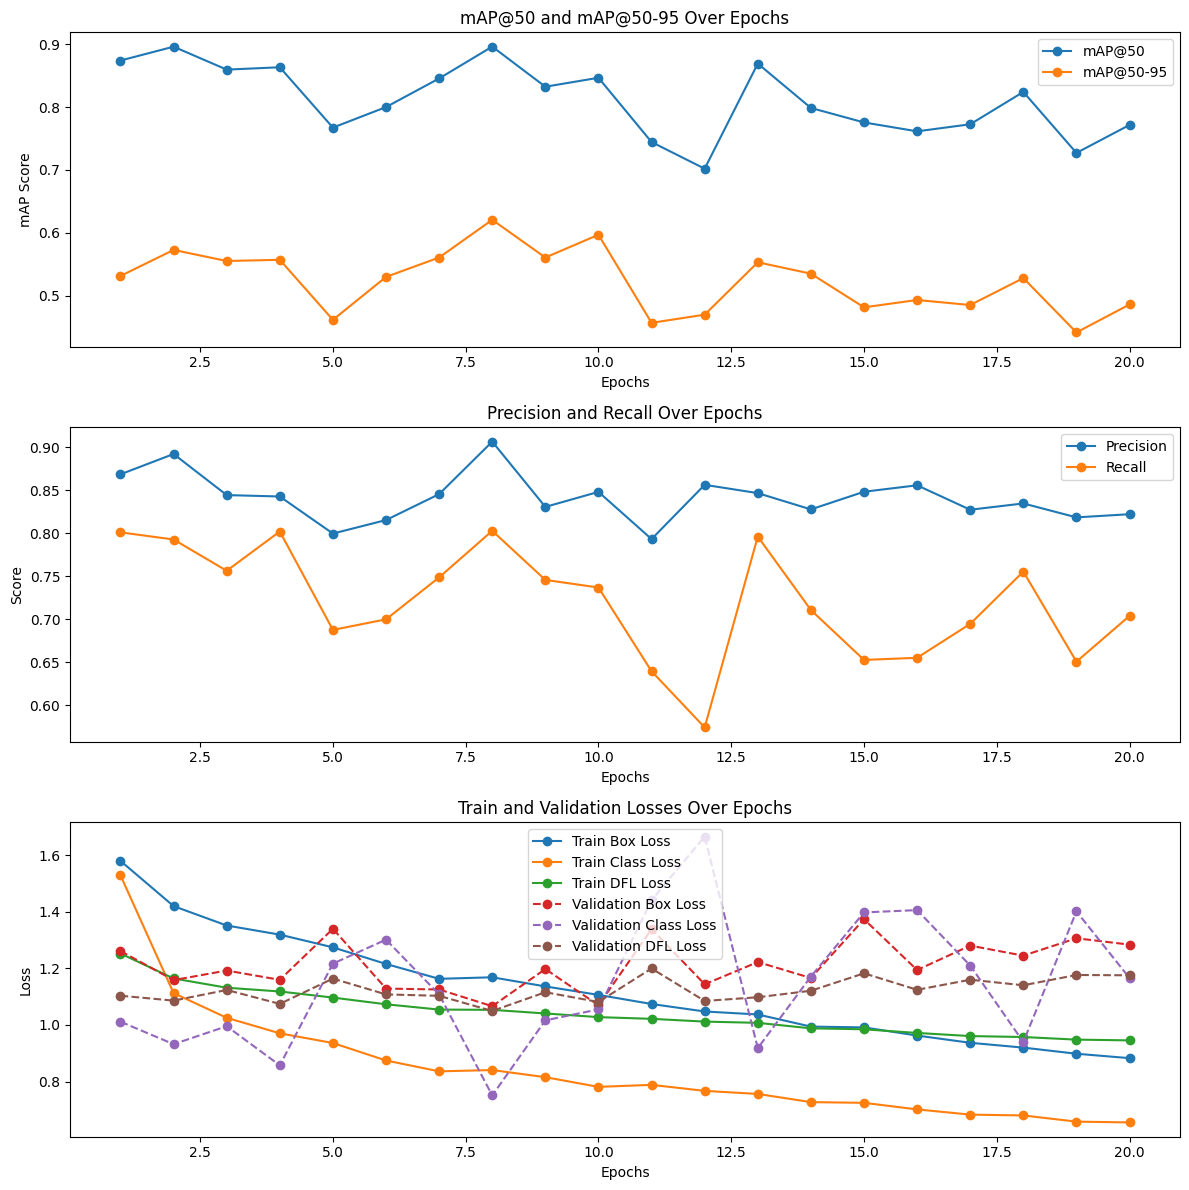

In [47]:
# Function to plot mAP and losses
def plot_metrics(df):
    plt.figure(figsize=(12, 12))

    # mAP Plot
    plt.subplot(3, 1, 1)
    plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50", marker='o')
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("mAP Score")
    plt.title("mAP@50 and mAP@50-95 Over Epochs")
    plt.legend()

    # Precision and Recall Plot
    plt.subplot(3, 1, 2)
    plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision", marker='o')
    plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Precision and Recall Over Epochs")
    plt.legend()

    # Train and Validation Losses Plot
    plt.subplot(3, 1, 3)
    plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", marker='o')
    plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", marker='o')
    plt.plot(df["epoch"], df["train/dfl_loss"], label="Train DFL Loss", marker='o')
    plt.plot(df["epoch"], df["val/box_loss"], label="Validation Box Loss", marker='o', linestyle='dashed')
    plt.plot(df["epoch"], df["val/cls_loss"], label="Validation Class Loss", marker='o', linestyle='dashed')
    plt.plot(df["epoch"], df["val/dfl_loss"], label="Validation DFL Loss", marker='o', linestyle='dashed')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Validation Losses Over Epochs")
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()

# Load the CSV file
def load_results(csv_path):
    return pd.read_csv(csv_path)


# Define the path to the results CSV
csv_path = "/kaggle/working/runs/detect/train3/results.csv"

# Load the results dataframe
df = load_results(csv_path)

# Plot the metrics
plot_metrics(df)


## **3-**


image 1/1 /kaggle/working/val/images/000639.jpg: 384x640 9 players, 39.1ms
Speed: 2.3ms preprocess, 39.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


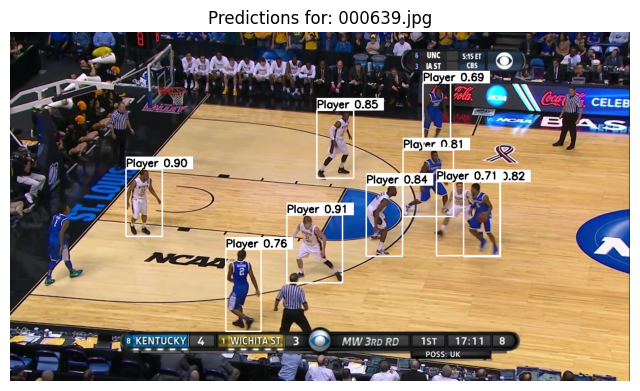


image 1/1 /kaggle/working/val/images/000759.jpg: 384x640 9 players, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


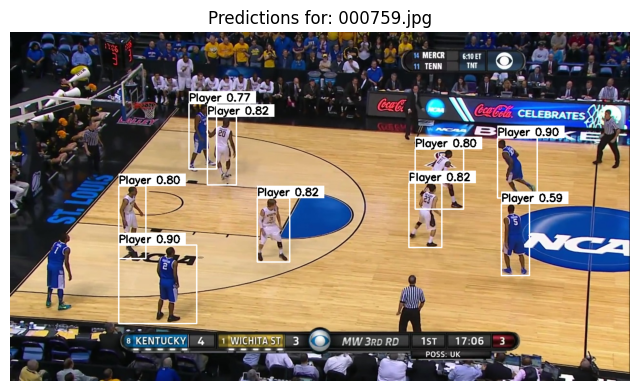


image 1/1 /kaggle/working/val/images/000905.jpg: 384x640 6 players, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


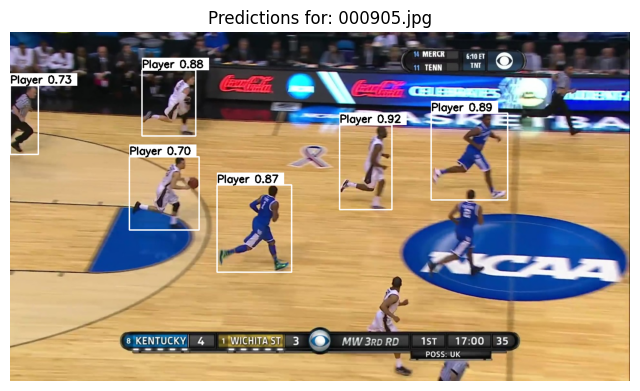


image 1/1 /kaggle/working/val/images/000454.jpg: 384x640 10 players, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


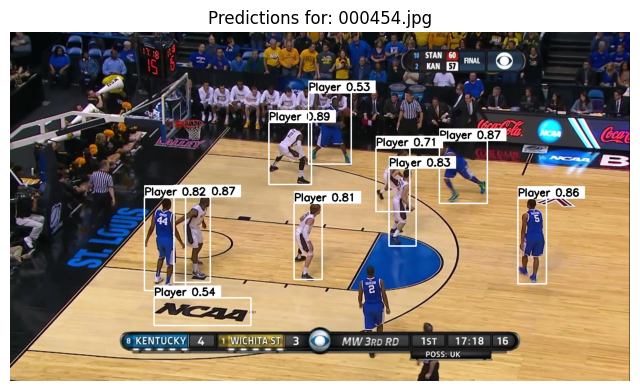


image 1/1 /kaggle/working/val/images/001198.jpg: 384x640 6 players, 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


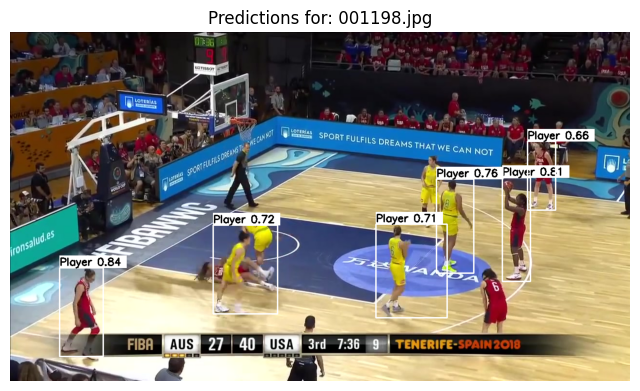


image 1/1 /kaggle/working/val/images/000327.jpg: 384x640 10 players, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


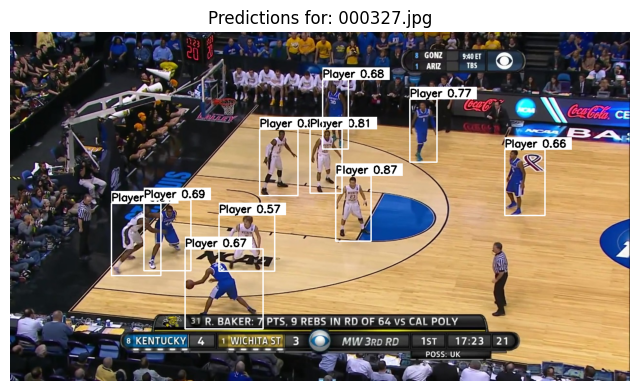


image 1/1 /kaggle/working/val/images/000277.jpg: 384x640 8 players, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


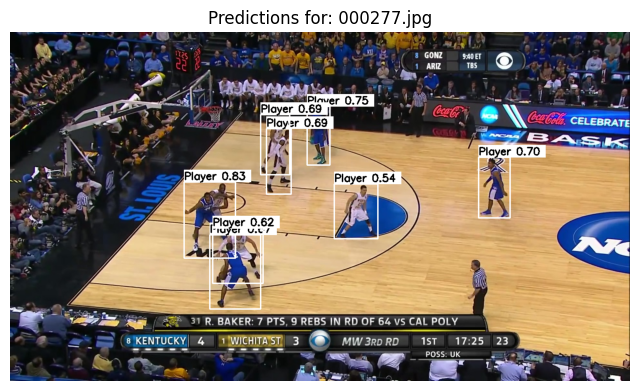


image 1/1 /kaggle/working/val/images/000904.jpg: 384x640 7 players, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


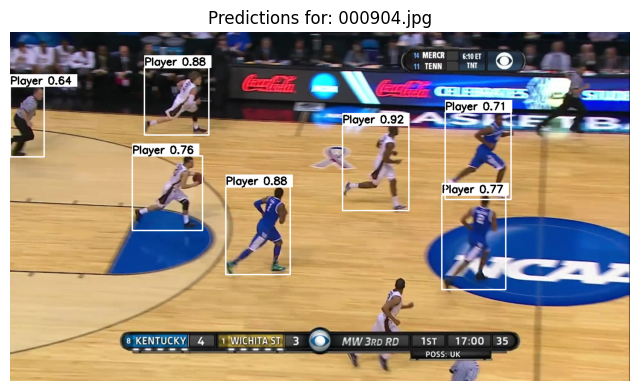

In [49]:
# Function to load the YOLO model
def load_model(model_path):
    return YOLO(model_path)

# Function to perform inference on an image
def perform_inference(model, img_path, conf_threshold=0.5):
    return model.predict(source=img_path, conf=conf_threshold, save=False)

# Function to process image and draw bounding boxes with labels
def process_and_draw_results(img, results):
    boxes = results[0].boxes.xyxy  # Bounding box coordinates
    confs = results[0].boxes.conf  # Confidence scores
    class_ids = results[0].boxes.cls.int()  # Class IDs

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)  # Convert to integer

        # Define colors
        box_color = (255, 255, 255)  # White
        text_color = (0, 0, 0)  # Black
        bg_color = (255, 255, 255)  # White background for text

        # Draw bounding box
        img = cv2.rectangle(img, (x1, y1), (x2, y2), box_color, 2)

        # Create label
        label = f"Player {confs[i]:.2f}"
        (text_width, text_height), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.75, 2
        )

        # Draw background rectangle for text
        cv2.rectangle(
            img,
            (x1, y1 - text_height - baseline),
            (x1 + text_width, y1),
            bg_color,
            thickness=cv2.FILLED,
        )

        # Put the label text on the image
        cv2.putText(
            img,
            label,
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            text_color,
            2,
        )
    return img

# Function to display image with predictions
def display_image_with_predictions(img, img_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predictions for: {img_name}")
    plt.show()

# Function to load and process multiple images
def process_images(model, img_dir, sample_size=8):
    sample_images = random.sample(os.listdir(img_dir), sample_size)

    for img_name in sample_images:
        img_path = os.path.join(img_dir, img_name)

        # Perform inference
        results = perform_inference(model, img_path)

        # Load image and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Process the image to draw bounding boxes and labels
        img = process_and_draw_results(img, results)

        # Display the image
        display_image_with_predictions(img, img_name)

# Define file paths
model_path = "runs/detect/train3/weights/best.pt"
val_images_path = "/kaggle/working/val/images"

# Load the model
model = load_model(model_path)

# Process and display images
process_images(model, val_images_path)

## **4-**

In [52]:
def extract_and_print_yolov8_metrics(results_dict):
    # Extract available metrics from the results dictionary
    metrics = {
        "mAP@50": results_dict["metrics/mAP50(B)"],  # mAP@50
        "mAP@50-95": results_dict["metrics/mAP50-95(B)"],  # mAP@50-95
        "Precision": results_dict["metrics/precision(B)"],  # Precision
        "Recall": results_dict["metrics/recall(B)"],  # Recall
        "Fitness Score": results_dict["fitness"]  # Model fitness score
    }

    # Print extracted metrics in a formatted way
    print("Validation Metrics:")
    print("===============================")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")
        print("===============================")

# Access YOLOv8 validation metrics
metrics_dict = results.results_dict

# Extract and print metrics
extract_and_print_yolov8_metrics(metrics_dict)

Validation Metrics:
mAP@50: 0.8964
mAP@50-95: 0.6206
Precision: 0.9060
Recall: 0.8036
Fitness Score: 0.6482


---
# Question 2.2: Single Object Tracking (SOT)

---

## **1-**


For our Single Object Tracking (SOT) task, we opted for the **CSRT (Channel and Spatial Reliability Tracking)** method due to its several key advantages, which make it particularly effective in the dynamic and complex environment of sports videos.

1. **High Accuracy and Robustness to Fast Movement**:
   - One of the primary reasons we chose CSRT is its **high tracking accuracy**. In sports videos, players often move rapidly, change directions suddenly, or even interact with one another. CSRT excels in accurately following objects with fast, unpredictable movements. It achieves this by using a **robust tracking mechanism** that combines spatial and channel reliability, which helps it keep track of the object even during fast motion, ensuring that the correct player is being followed across frames.

2. **Handling Scale Variations and Occlusions**:
   - Another significant advantage of CSRT is its ability to **adapt to changes in object scale**. In sports, players frequently move closer to or further from the camera, causing them to appear larger or smaller in the frame. CSRT handles these **scale variations** very well, maintaining stable tracking even when the size of the player changes. Additionally, CSRT is **resilient to partial occlusions**, which is crucial for sports, where players often momentarily block each other. The tracker can maintain its focus on the object, continuing to track the player even when parts of the player are temporarily hidden behind another object or person.

3. **Robust to Environmental Challenges**:
   - Sports environments can present a variety of challenges, such as changing lighting conditions, complex backgrounds, and noise. CSRT is particularly **resilient to noisy environments**, which makes it ideal for the cluttered and dynamic backgrounds often seen in sports videos. Whether it's a shift in the lighting or background distractions like the crowd or other players, CSRT's adaptive nature ensures it remains focused on the target object. Its ability to compute both **spatial reliability** (how reliably a region matches the object) and **channel reliability** (how likely a region belongs to the object) allows it to effectively handle these challenges.

4. **Accuracy in Localization and Object Appearance**:
   - CSRT provides **precise localization** of the object, which is critical for accurately following players in sports. By focusing on the object’s appearance, CSRT ensures that the **bounding box is tightly aligned** with the player's position, even as they move or rotate. This precise localization is essential for tasks like tracking a player across multiple frames, especially in sports where players may frequently change posture or angle, such as during running, tackling, or shooting.

5. **Handling Rotation and Non-Rigid Deformations**:
   - Unlike some other tracking methods, CSRT is particularly good at handling **rotations and non-rigid deformations**. In sports, players often rotate or change their posture during actions like turning, jumping, or making complex movements. CSRT's ability to maintain tracking despite these **non-rigid deformations** ensures that it can continue to follow players accurately even when their shape or orientation changes, which is very common in sports scenarios.

6. **Ease of Implementation and Integration**:
   - Finally, the CSRT tracker is part of **OpenCV**, a widely-used computer vision library. This makes it very **easy to implement and integrate** into our existing tracking pipeline. OpenCV provides highly optimized functions for CSRT that can be quickly adapted to our project, ensuring that we can get started with minimal setup and can take advantage of the performance improvements that come with OpenCV's implementation.

## **2-**



In [118]:
# Paths to the input video, output video, and YOLO model weights
INPUT_FRAMES_DIRECTORY = "/kaggle/input/sportsmot_publish/dataset/val/v_9MHDmAMxO5I_c004/img1"  # Path to your input frames
OUTPUT_VIDEO_PATH = "/kaggle/working/output_video_SOT.mp4"  # Output path for the tracked video
YOLO_MODEL_WEIGHTS_PATH = "/kaggle/working/runs/detect/train3/weights/best.pt"  # Path to YOLO model weights
TRACKING_RESULTS_DIRECTORY = "/kaggle/working/SOT_Results/"
os.makedirs(TRACKING_RESULTS_DIRECTORY, exist_ok=True)

# Class names and color assignments for visualization
CLASS_LABELS = ["player", "referee", "ball"]
CLASS_COLORS = {
    "player": (255, 255, 0),   # Yellow
    "referee": (0, 0, 255),    # Red
    "ball": (255, 0, 255)      # Magenta
}

# YOLO detection threshold and video frame configuration
CONFIDENCE_THRESHOLD = 0.5
FRAME_SIZE = (1280, 720)      # Resolution of output frames
FPS = 25                     # Frames per second for output video

# Initialize CSRT tracker
tracker = cv2.TrackerCSRT_create()

# Load the YOLO model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_model = YOLO(YOLO_MODEL_WEIGHTS_PATH).to(device)

# Get sorted list of frame files (sorted by frame number)
frame_files = sorted([f for f in os.listdir(INPUT_FRAMES_DIRECTORY) if f.endswith(('.jpg', '.png'))],
                     key=lambda x: int(x.split('.')[0]))

# Initialize video writer for saving the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, FPS, FRAME_SIZE)

# Flag to initialize the tracking region
initialized = False

# Process frames and track objects
for frame_index, frame_file in enumerate(frame_files):

    frame_path = os.path.join(INPUT_FRAMES_DIRECTORY, frame_file)
    frame = cv2.imread(frame_path)
    frame = cv2.resize(frame, FRAME_SIZE)  # Ensure 720p resolution

    # Run YOLO model to detect objects
    detection_results = yolo_model(frame, device=device, verbose=False)[0]

    detected_boxes = []
    if detection_results.boxes is not None:
        boxes = detection_results.boxes.xyxy.cpu().numpy()  # Get box coordinates (x_min, y_min, x_max, y_max)
        confidences = detection_results.boxes.conf.cpu().numpy()

        # Filter detections by confidence threshold
        for i, box in enumerate(boxes):
            if confidences[i] < CONFIDENCE_THRESHOLD:
                continue
            xmin, ymin, xmax, ymax = map(int, box)
            width, height = xmax - xmin, ymax - ymin
            detected_boxes.append([[xmin, ymin, width, height], confidences[i]])

    # Initialize the CSRT tracker with the first detection (if not initialized)
    if not initialized and detected_boxes:
        xmin, ymin, width, height = detected_boxes[0][0]
        bbox = (xmin, ymin, width, height)  # Format: (x, y, width, height)
        tracker.init(frame, bbox)  # Initialize the tracker with the first detected object
        initialized = True

    # Update the tracker with the current frame
    success, bbox = tracker.update(frame)

    # Write tracking results to file
    if success:
        x, y, w, h = [int(v) for v in bbox]
        track_id = 1  # For CSRT, we don't track multiple objects by default (extendable for multi-object tracking)
        class_name = "player"  # Placeholder, extendable for multiple classes
        color = CLASS_COLORS.get(class_name, (255, 255, 255))

        frame_number = frame_index + 1  # Frame number starts from 1
        confidence = 1.0  # Placeholder, can be added if tracking confidence is available

        result_line = f"{frame_number},{track_id},{x},{y},{w},{h},{confidence},-1,-1,-1\n"
        with open(os.path.join(TRACKING_RESULTS_DIRECTORY, "tracking_results_CSRT.txt"), "a") as result_file:
            result_file.write(result_line)

        label = f"{track_id}. {class_name} ({confidence})"

        # Draw bounding box and label on the frame
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    else:
        cv2.putText(frame, "Tracking failed", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)  # Red text for failure

    # Write the processed frame to the output video
    video_writer.write(frame)

# Release video writer and finalize processing
video_writer.release()

Video processing completed successfully!


## **3-**

The **CSRT (Channel and Spatial Reliability Tracking)** algorithm is a powerful tool for **single-object tracking (SOT)** and is capable of handling a variety of challenges in object tracking, such as **occlusion**, **scale variation**, and **illumination changes**. However, like any tracking algorithm, **CSRT** has its limitations when faced with these common challenges. Let’s investigate these issues in more detail:

### 1. **Occlusion**:
   - **Challenge**: **Occlusion** occurs when an object is temporarily blocked by another object in the scene (e.g., one player blocking another in a sports video, or a car hidden behind another vehicle in a traffic video). During occlusion, the tracker may lose track of the object because it is no longer visible, and the tracker cannot update the object’s position.
   - **Impact on CSRT**: CSRT relies on **spatial and appearance information** to track objects. When an object is occluded, the tracker cannot see it to update the tracking information. As a result, it might lose track of the object completely or make incorrect predictions about its location when it reappears.
   - **Possible Solutions**:
     - **Longer Track Persistence**: CSRT has a `max_age` parameter that determines how many frames the tracker will continue to predict an object’s location when it is not detected. Increasing this parameter can help track objects during short occlusions.
     - **Using Motion Prediction**: In some cases, the **motion model** used by CSRT (based on object velocity and direction) can help predict where the object might appear after an occlusion, improving tracking continuity.
     - **Re-detection**: After an occlusion, **YOLO detection** can be used again to detect the object’s position once it becomes visible again, reinitializing the CSRT tracker.

### 2. **Scale Variation**:
   - **Challenge**: **Scale variation** refers to the change in the size of an object in the video due to movement toward or away from the camera, or a change in the object’s orientation. For example, in sports tracking, a player moving closer to the camera will appear larger, while one moving away will appear smaller.
   - **Impact on CSRT**: CSRT can handle **small scale variations** to some extent, as it is designed to adapt to changes in object appearance (via spatial reliability). However, it may struggle with **large changes in scale** (e.g., a small player becoming very large as they move toward the camera), leading to inaccurate bounding box predictions.
   - **Possible Solutions**:
     - **Scale-aware Tracking**: While CSRT handles moderate scale changes well, if the scale variation is extreme, using a **multi-scale tracking approach** might be necessary. This involves using multiple trackers at different scales or resizing the input image at different scales and tracking across them.
     - **Appearance Model Adjustment**: The **appearance model** of CSRT can be adapted by re-calculating feature descriptors as the object changes in scale. This can help the tracker to update its representation of the object’s appearance when it changes size.
     - **Faster Object Re-initialization**: Using a **detection-based re-initialization** approach can also help. If the object’s scale changes significantly and tracking becomes unreliable, using **YOLO to detect the object** again and resetting the tracker can handle large scale changes.

### 3. **Illumination Changes**:
   - **Challenge**: **Illumination changes** refer to the changes in lighting that occur during a video, such as objects moving from well-lit areas to shadows, or drastic changes in lighting (e.g., from day to night or due to sudden light sources like headlights). These changes can significantly alter the appearance of the object, making it harder for the tracker to maintain the same representation of the object.
   - **Impact on CSRT**: Since CSRT relies heavily on appearance features (such as color, texture, and edges), illumination changes can cause **appearance mismatches**. This results in the tracker either losing the object or incorrectly predicting its location.
   - **Possible Solutions**:
     - **Illumination Normalization**: One approach to mitigate the impact of illumination changes is to use **illumination normalization** techniques, such as converting the image to a color space (like **HSV** or **YUV**) where lighting conditions have less impact on object appearance. This helps reduce the influence of illumination changes on the appearance model.
     - **Appearance Feature Adjustment**: CSRT uses **spatial reliability** to improve object tracking in varying conditions, including lighting changes. However, further adjustments to the feature extraction model (e.g., using **deep learning models** that are robust to lighting changes) could improve the tracker's ability to handle such variations.
     - **Robust Re-detection**: Using **YOLO for re-detection** in the case of significant illumination changes can be an effective strategy. If tracking fails due to lighting, detecting the object with YOLO and resetting the tracker might provide a better solution.

### 4. **Other Considerations**:
   - **Fast Motion**: **Fast motion** can cause problems for CSRT, as the object may move too quickly between frames, making it difficult for the tracker to update the bounding box accurately.
     - **Solution**: One solution is using **motion prediction** models (like Kalman filters) to predict the object's next position, helping the tracker to handle fast movements more effectively.
   
   - **Occlusion + Scale Variation + Illumination Change**: When all these challenges occur simultaneously (e.g., a player moves quickly toward the camera, gets partially occluded by a teammate, and the lighting changes), CSRT might struggle to maintain an accurate track.
     - **Solution**: Combining **multiple tracking techniques** (e.g., using **DeepSORT** with **CSRT** for appearance matching) can help address these combined challenges by providing more robust tracking, especially for challenging scenarios like these.

## **4-**


In [124]:
# Paths to the input video, output video, and YOLO model weights
INPUT_FRAMES_DIRECTORY = "/kaggle/input/sportsmot_publish/dataset/val/v_9MHDmAMxO5I_c004/img1"  # Path to your input frames
OUTPUT_VIDEO_PATH = "/kaggle/working/output_video_SOT.mp4"  # Output path for the tracked video
YOLO_MODEL_WEIGHTS_PATH = "/kaggle/working/runs/detect/train3/weights/best.pt"  # Path to YOLO model weights
GROUND_TRUTH_FILE = "/kaggle/input/sportsmot_publish/dataset/val/v_9MHDmAMxO5I_c004/gt/gt.txt"  # Ground truth file path

# Class names and color assignments for visualization
CLASS_LABELS = ["player", "referee", "ball"]
CLASS_COLORS = {
    "player": (255, 255, 0),   # Yellow
    "referee": (0, 0, 255),    # Red
    "ball": (255, 0, 255)      # Magenta
}

# YOLO detection threshold and video frame configuration
CONFIDENCE_THRESHOLD = 0.5
FRAME_SIZE = (1280, 720)      # Resolution of output frames
FPS = 25                     # Frames per second for output video

# Initialize CSRT tracker
tracker = cv2.TrackerCSRT_create()

# Load the YOLO model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_model = YOLO(YOLO_MODEL_WEIGHTS_PATH).to(device)

# Get sorted list of frame files (sorted by frame number)
frame_files = sorted([f for f in os.listdir(INPUT_FRAMES_DIRECTORY) if f.endswith(('.jpg', '.png'))],
                     key=lambda x: int(x.split('.')[0]))

# Initialize video writer for saving the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, FPS, FRAME_SIZE)

# Flag to initialize the tracking region
initialized = False

# Function to load and parse ground truth file
def load_and_parse_gt(gt_file):
    """
    Load and parse the ground truth file for MOT metrics evaluation.
    """
    try:
        # Try reading the ground truth with an automatic separator and handling malformed lines
        gt_data = pd.read_csv(gt_file, sep=r'\s+', header=None, 
                              names=['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'cls', 'vis', 'occlusion', 'empty', 'empty2'], 
                              engine='python', on_bad_lines='skip')
        print(f"Ground truth file loaded successfully with shape: {gt_data.shape}")
    except Exception as e:
        print(f"Error loading ground truth file: {e}")
        return None
    return gt_data

# Variables for performance evaluation
detected_boxes = []
gt_boxes = []  # Ground truth boxes for evaluation
track_ids = []
gt_ids = []

# Process frames and track objects
for frame_index, frame_file in enumerate(frame_files):

    frame_path = os.path.join(INPUT_FRAMES_DIRECTORY, frame_file)
    frame = cv2.imread(frame_path)
    frame = cv2.resize(frame, FRAME_SIZE)  # Ensure 720p resolution

    # Run YOLO model to detect objects
    detection_results = yolo_model(frame, device=device, verbose=False)[0]

    detected_boxes.clear()  # Clear previous detections

    if detection_results.boxes is not None:
        boxes = detection_results.boxes.xyxy.cpu().numpy()  # Get box coordinates (x_min, y_min, x_max, y_max)
        confidences = detection_results.boxes.conf.cpu().numpy()

        # Process detections with a confidence threshold
        for i, box in enumerate(boxes):
            if confidences[i] < CONFIDENCE_THRESHOLD:
                continue
            xmin, ymin, xmax, ymax = map(int, box)
            width, height = xmax - xmin, ymax - ymin
            detected_boxes.append([xmin, ymin, width, height])

    # Initialize tracker with the first detection
    if not initialized and len(detected_boxes) > 0:
        bbox = detected_boxes[0]
        tracker.init(frame, tuple(bbox))  # Initialize the CSRT tracker
        initialized = True

    # Update the tracker with the current frame
    success, bbox = tracker.update(frame)

    if success:
        x, y, w, h = [int(v) for v in bbox]
        track_ids.append(1)  # Assign a static ID since CSRT is single-object tracking
        gt_ids.append(1)  # Placeholder for ground truth ID

        # Drawing bounding box and label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green bounding box
        cv2.putText(frame, f"ID: {1}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Write processed frame to the output video
    video_writer.write(frame)

# Release video writer and finalize processing
video_writer.release()

# Load ground truth for evaluation (example format: frame, id, x, y, width, height)
gt_data = load_and_parse_gt(GROUND_TRUTH_FILE)

if gt_data is not None:
    # Convert both GT and tracking results to the correct format
    gt_mot = mm.io.load_motchallenge(GROUND_TRUTH_FILE)  # This should now work if the file is parsed correctly
    tracker_results = []

    for frame_number, track_id, bbox in zip(range(1, len(track_ids) + 1), track_ids, detected_boxes):
        # Match tracking results with ground truth (frame, id, bbox)
        tracker_results.append([frame_number, track_id, *bbox])

    # Convert to motmetrics format
    tracker_results = np.array(tracker_results)

    # Create a motmetrics 'acc' object for evaluation
    gt = mm.io.load_motchallenge(GROUND_TRUTH_FILE)
    ts = mm.utils.convert_to_motchallenge_format(tracker_results)

    # Compare tracking results with ground truth
    acc = mm.utils.compare_to_groundtruth(gt, ts, 'iou', distth=0.5)
    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=[
        'mota', 'precision', 'recall', 'motp', 'idf1', 'idp', 'idr', 
        'num_switches', 'mostly_tracked', 'partially_tracked', 'mostly_lost'
    ], name='acc')

    # Display results
    summary_df = pd.DataFrame(summary).transpose()
    print(summary_df)


ValueError: 9 columns passed, passed data had 10 columns

## **5-**

**CSRT (Channel and Spatial Reliability Tracking)** works well under the following conditions:

1. **Moderate Occlusion**: CSRT can handle partial occlusions where the object is briefly blocked but still largely visible.
2. **Small to Moderate Scale Variations**: The algorithm performs well when objects change size moderately, such as when they move closer or further away without drastic size changes.
3. **Stable Motion**: It tracks objects effectively when they move predictably with smooth trajectories, without rapid or erratic changes in direction.
4. **Consistent Appearance**: CSRT works well when the object’s appearance remains relatively stable (minimal illumination change, texture or color change).
5. **Low Background Clutter**: It is effective when the background is simple and there are no many similar objects, reducing the risk of confusion in object identification.

**CSRT has errors in the following conditions**:

1. **Long or Full Occlusion**: If the object is completely hidden for an extended period, CSRT may lose track due to a lack of visual data.
2. **Large Scale Variations**: CSRT struggles with significant changes in the object’s size, such as when objects move too far away or close to the camera.
3. **Fast Motion**: When objects move too quickly, CSRT may fail to accurately update the position and bounding box.
4. **Significant Illumination Changes**: Sudden or large lighting changes can cause appearance mismatches, leading to tracking errors.
5. **Multiple Similar Objects**: If many similar objects are present, CSRT may struggle to differentiate between them, leading to ID switches.

---
# Question 2.3: Multiple Object Tracking (MOT)

---

## **1-**

For our **Multiple Object Tracking (MOT)** task in sports videos, we chose to implement the **DeepSORT (Deep Learning-based SORT)** algorithm due to its robust performance, efficiency, and its suitability for handling the complex, dynamic nature of sports scenes. Here are the key reasons why **DeepSORT** is the ideal choice for tracking multiple objects (such as players) in sports videos:

### 1. **Combination of Detection and Re-Identification**:
   - DeepSORT is a **deep learning-based extension** of the classic SORT (Simple Online and Realtime Tracking) algorithm. While SORT relies on Kalman filters and data association to track objects, DeepSORT adds a **re-identification step** that uses deep learning models to generate appearance features for each object (in this case, each player). This is crucial for sports videos, where players may be occluded or reappear after being out of frame. The re-ID step allows DeepSORT to **maintain consistent tracking IDs**, even if a player briefly disappears from the frame due to occlusion or crowd interactions.
   
   **Advantage**: This re-identification capability is particularly important in sports where players often overlap or are temporarily obscured by other objects or players. DeepSORT can successfully track players even when they are out of view or when multiple players are interacting closely.

### 2. **Robust to Occlusions and Close Interactions**:
   - In sports, players frequently experience partial occlusion (e.g., one player blocking another) or very close interactions (e.g., a group of players forming a huddle). DeepSORT’s use of appearance features, in combination with the **Kalman filter**, helps it to **predict and maintain track continuity** despite these challenges. The algorithm combines the motion model and the appearance model to re-associate objects accurately when they become visible again after being occluded.
   
   **Advantage**: This robustness to occlusions and close interactions makes DeepSORT especially effective for sports videos, where player movements are often erratic, and occlusion is a frequent occurrence (e.g., during tackles, goal celebrations, or close ball interactions).

### 3. **Real-Time Performance**:
   - DeepSORT is known for its **real-time tracking** capabilities, which is essential when processing high-frame-rate sports videos. The combination of the Kalman filter and the appearance model enables DeepSORT to track multiple objects simultaneously with minimal computational overhead. As sports videos typically involve rapid motion and fast-paced actions, it’s important that the tracking algorithm can run efficiently in real-time, without sacrificing tracking accuracy.
   
   **Advantage**: DeepSORT’s efficiency and speed allow it to be deployed in scenarios that require real-time analysis, such as tracking players across multiple camera views or during live sports broadcasts.

### 4. **Scalability to Handle Multiple Players**:
   - Sports videos often involve a large number of objects (players) that need to be tracked simultaneously. DeepSORT’s architecture is designed to handle **scalable multi-object tracking**, making it capable of tracking a large number of players across different frames. It efficiently associates detections from an object detector (such as YOLO) with tracked objects, allowing it to scale to scenarios where many players are present, such as team sports like soccer or basketball.
   
   **Advantage**: DeepSORT can handle the complexity of tracking multiple players simultaneously, making it a good fit for team sports where many objects (players) need to be tracked in parallel.

### 5. **Integration with Modern Object Detectors**:
   - DeepSORT is highly effective when paired with modern object detection models, such as **YOLO** or **Faster R-CNN**, which can provide accurate bounding box detections of players. By combining DeepSORT with these detectors, you get the best of both worlds: accurate detection and reliable tracking. The appearance features learned by DeepSORT from the detected objects help maintain tracking accuracy even in challenging conditions.
   
   **Advantage**: By using a strong object detector along with DeepSORT, we can leverage high-quality detections and combine them with the power of tracking, ensuring reliable performance across frames in sports videos.

### 6. **Fine-Grained Player Tracking and ID Management**:
   - In sports analysis, it is essential to **track individual players** and maintain their identity over time (e.g., for performance analysis, stats collection, etc.). DeepSORT does a great job of **assigning consistent IDs** to each player, ensuring that the player’s identity remains intact even as they move around the field, change positions, or interact with teammates and opponents.
   
   **Advantage**: This fine-grained ID management is crucial for detailed sports analysis, such as player tracking, team strategies, and performance metrics.

### 7. **Flexibility and Customization**:
   - DeepSORT is flexible and can be customized to different sports applications. It allows for easy adjustments to suit specific requirements, such as modifying the appearance feature extractor, tuning the parameters of the Kalman filter, or integrating other detection methods. This flexibility makes it adaptable to various sports contexts, whether you're tracking players in soccer, basketball, or any other team-based sport.
   
   **Advantage**: The adaptability of DeepSORT makes it versatile, allowing it to be tailored to the unique demands of different sports and video conditions.

## **2-**

Object detection and object tracking are two essential tasks in computer vision that are often used together in applications such as video analysis, surveillance, and sports analytics. **Object detection** is the process of identifying and locating objects within a single frame of a video or image. The output of an object detection algorithm typically consists of **bounding boxes** that indicate the location of each detected object, a **class label** (such as “person” or “car”), and a **confidence score** that represents how sure the model is about its detection. In sports videos, for example, an object detection algorithm might detect players, the ball, or the referee with bounding boxes.

While object detection can identify the presence of objects in a single frame, it does not track how these objects move across a sequence of frames. This is where **object tracking** comes into play. **Object tracking** aims to follow objects over time, maintaining their identity and location as they move across different frames in the video. The tracker’s goal is to continuously associate objects detected in each frame with their corresponding objects from previous frames, even as they move or interact with other objects. It assigns a unique identifier (ID) to each object and updates the position of the object in each subsequent frame.

The relationship between object detection and object tracking is straightforward. **Object detection provides the initial bounding boxes and class labels** for each object in a given frame, which then serve as the **input to the object tracking algorithm**. In the first frame, object detection detects the objects and their locations, but tracking is necessary to follow those objects across all future frames. The tracker uses the detection results to update the positions of the objects, predict their future locations, and maintain consistent IDs across frames. This is especially useful in scenarios where objects are continuously moving, like players in a sports video.

The tracker processes the detections in each new frame and associates them with previous detections. In more advanced tracking algorithms, such as **DeepSORT**, the tracker not only uses spatial information from the bounding boxes but also incorporates appearance features, which help in distinguishing between objects, especially when they are close to each other or occluded. For example, in sports, when one player temporarily blocks another, the appearance features help the tracker re-identify the occluded player when they reappear. Additionally, motion models, such as Kalman filters, are often used to predict the future positions of objects, further improving the robustness of the tracking algorithm.

In summary, object detection and object tracking work together to provide continuous, real-time analysis of moving objects in a sequence of frames. **Object detection** provides the initial identification of objects, while **object tracking** ensures that these objects are consistently followed across frames, even in challenging conditions such as occlusions, fast movement, or changes in appearance. This synergy allows for effective object tracking in applications such as sports video analysis, where it is critical to follow and maintain the identity of players, balls, and other objects throughout a match.

## **3-**

In the **DeepSORT (Deep Learning-based SORT)** algorithm, the **assignment process** refers to the mechanism used to match detected objects in one frame to their corresponding objects in the next frame. This is a crucial part of the **tracking** process, as it ensures that the algorithm can maintain **consistent identities** (IDs) for objects over time, even as they move, occlude, or interact with other objects.

### Mechanisms for Matching in Sequential Frames:
DeepSORT uses a combination of two key mechanisms for matching objects across frames:

1. **Motion Model (Kalman Filter)**:
   - DeepSORT employs a **Kalman filter** to predict the location of each tracked object in the current frame, based on its previous position and velocity. This helps the tracker predict where an object should be in the next frame, even if the object is temporarily occluded or out of view. The Kalman filter essentially uses the object's **motion dynamics** to estimate its future position, and this prediction serves as a **prior belief** about where the object will appear in the next frame.
   - The motion model is particularly useful for handling **fast-moving objects** or objects that are partially occluded in one frame but reappear in the next. The Kalman filter adjusts the object's position according to its velocity and previous trajectory.

2. **Appearance Features (Deep Learning Model)**:
   - In addition to the motion model, DeepSORT also uses **appearance features** to help differentiate between objects, even if they are spatially close or overlapping. A **deep neural network** (usually a CNN) is used to extract **appearance features** (e.g., color, texture, shape) from the object detections. These features are embedded into a feature vector, which serves as a representation of the object's appearance.
   - When matching objects across frames, DeepSORT compares the appearance feature vectors of the objects detected in the current frame to those in the previous frame. This helps ensure that the tracker can distinguish between objects that may look similar but are different, such as two players in a sports video with similar shapes or colors.

### Assignment Process in DeepSORT:
The assignment of detected objects to existing tracks in DeepSORT is typically done using the **Hungarian algorithm** or a similar optimization technique. Here’s how the matching works:

1. **Feature Vector Comparison**: For each detection in the current frame, DeepSORT computes a **cost matrix** based on two main components:
   - **Motion Cost**: The Kalman filter's predicted position and the actual detection are compared to determine how well the predicted position matches the detection. If the predicted position is far from the detection, the cost is higher.
   - **Appearance Cost**: The appearance feature vector of each detection is compared to the feature vector of existing tracks. A distance metric, typically **Euclidean distance**, is used to measure how similar the appearance features are. If the features are very similar, the cost is low; if they are very different, the cost is high.

2. **Hungarian Algorithm**: The **Hungarian algorithm** (or **Munkres algorithm**) is then used to solve the **assignment problem**. It finds the optimal matching between the detected objects and the existing tracks based on the combined motion and appearance costs. The algorithm minimizes the overall cost by matching detections to tracks in a way that minimizes the sum of both the motion and appearance costs.

3. **Track Management**:
   - If a detection matches an existing track with a low cost (i.e., both the motion prediction and appearance features are similar), the track is updated with the new detection’s information (e.g., its new bounding box).
   - If no suitable match is found for a detection (i.e., the cost is too high), a new track is created for that detection.
   - If an object is not detected in a frame (e.g., it’s occluded or out of view), the tracker may **drop the track** after a certain number of frames (depending on the **max_age** parameter), or it will continue predicting the object’s position using the motion model.

## **4-**

In [90]:
# Directory and file paths
INPUT_FRAMES_DIRECTORY = "/kaggle/input/sportsmot_publish/dataset/val/v_0kUtTtmLaJA_c006/img1"
OUTPUT_VIDEO_PATH = "/kaggle/working/output_video_MOT.mp4"
YOLO_MODEL_WEIGHTS_PATH = "/kaggle/working/runs/detect/train3/weights/best.pt"
TRACKING_RESULTS_DIRECTORY = "/kaggle/working/MOT_Results/"
os.makedirs(TRACKING_RESULTS_DIRECTORY, exist_ok=True)

# Class names and color assignments for visualization
CLASS_LABELS = ["player", "referee", "ball"]
CLASS_COLORS = {
    "player": (255, 255, 0),   # Yellow
    "referee": (0, 0, 255),    # Red
    "ball": (255, 0, 255)      # Magenta
}

# YOLO detection threshold and video frame configuration
CONFIDENCE_THRESHOLD = 0.5
FRAME_SIZE = (1280, 720)      # Resolution of output frames
FPS = 25                     # Frames per second for output video

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=5, n_init=1, nms_max_overlap=0.2)

# Load the YOLO model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_model = YOLO(YOLO_MODEL_WEIGHTS_PATH).to(device)

# Get sorted list of frame files (sorted by frame number)
frame_files = sorted([f for f in os.listdir(INPUT_FRAMES_DIRECTORY) if f.endswith(('.jpg', '.png'))],
                     key=lambda x: int(x.split('.')[0]))

In [113]:
# Initialize video writer for saving the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, FPS, FRAME_SIZE)

# Process frames and track objects
for frame_index, frame_file in enumerate(frame_files):

    frame_path = os.path.join(INPUT_FRAMES_DIRECTORY, frame_file)
    frame = cv2.imread(frame_path)
    frame = cv2.resize(frame, FRAME_SIZE)  # Ensure 720p resolution

    # Run YOLO model to detect objects
    detection_results = yolo_model(frame, device=device, verbose=False)[0]

    detected_boxes = []
    if detection_results.boxes is not None:
        boxes = detection_results.boxes.xyxy.cpu().numpy()  # Get box coordinates (x_min, y_min, x_max, y_max)
        confidences = detection_results.boxes.conf.cpu().numpy()

        # Filter detections by confidence threshold
        for i, box in enumerate(boxes):
            if confidences[i] < CONFIDENCE_THRESHOLD:
                continue
            xmin, ymin, xmax, ymax = map(int, box)
            width, height = xmax - xmin, ymax - ymin
            detected_boxes.append([[xmin, ymin, width, height], confidences[i]])

    # Update the tracker with new detections
    tracks = tracker.update_tracks(detected_boxes, frame=frame)

    # Write tracking results to file
    with open(os.path.join(TRACKING_RESULTS_DIRECTORY, "results_MOT.txt"), "a") as result_file:
        for track in tracks:
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            class_name = track.det_class
            color = CLASS_COLORS.get(class_name, (255, 255, 255))

            frame_number = frame_index + 1  # Frame number starts from 1
            x1, y1, x2, y2 = track.to_ltrb()  # Get bounding box coordinates
            confidence = str(track.det_conf)[:4]

            result_line = f"{frame_number},{track_id},{x1},{y1},{x2-x1},{y2-y1},{confidence},-1,-1,-1\n"
            result_file.write(result_line)

            x1, y1, width, height = map(int, track.to_ltwh())  # Convert to left, top, width, height format
            x2, y2 = x1 + width, y1 + height
            label = f"{track_id}. {class_name} ({confidence})"

            # Draw bounding box and label on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Write the processed frame to the output video
    video_writer.write(frame)

# Release video writer and finalize processing
video_writer.release()
print("Video processing completed successfully!")

Video processing completed successfully!


## **5-**

In [ ]:
# Function to compute MOT metrics (MOTA, precision, recall, etc.)
def calculate_tracking_metrics(ground_truth_file, tracking_results_file):

    # Load ground truth and tracking results
    ground_truth = mm.io.load_motchallenge(ground_truth_file)
    tracking_results = mm.io.load_motchallenge(tracking_results_file)

    # Calculate comparison metrics based on IOU threshold
    accuracy = mm.utils.compare_to_groundtruth(ground_truth, tracking_results, 'iou', distth=0.5)
    
    # Create an instance of MOT metrics
    mot_metrics = mm.metrics.create()

    # Compute the summary of tracking performance
    metrics_summary = mot_metrics.compute(accuracy, metrics=[
        'mota', 'precision', 'recall', 'motp', 'idf1', 'idp', 'idr',
        'num_switches', 'mostly_tracked',
        'partially_tracked', 'mostly_lost'
    ], name='tracking_accuracy')

    # Convert the summary into a pandas DataFrame
    summary_df = pd.DataFrame(metrics_summary).transpose()

    return summary_df

# Example usage of the function to compute MOT metrics
ground_truth_file_path = "/kaggle/input/sportsmot_publish/dataset/val/v_0kUtTtmLaJA_c006/gt/gt.txt"
tracking_results_file_path = "/kaggle/working/MOT_Results/results_MOT.txt"
metrics_summary = calculate_tracking_metrics(ground_truth_file_path, tracking_results_file_path)
print(metrics_summary)

## **6-**

The **DeepSORT** algorithm is widely used for **Multiple Object Tracking (MOT)** because of its effectiveness in tracking objects over time. However, like any tracking algorithm, it faces a variety of challenges in real-world applications. These challenges often arise due to changes in the environment, object interactions, and detection limitations. Let's investigate some of the common challenges that **DeepSORT** encounters, including **ID switching**, **occlusion**, and **illumination changes**.

### 1. **ID Switching**:
   - **Problem**: **ID switching** occurs when the tracking algorithm mistakenly switches the identity of two objects. This usually happens when two or more objects are detected close to each other or when there is high interaction between them (e.g., players running past each other in sports).
   - **Cause**: This happens because the **appearance feature vectors** (which DeepSORT uses to distinguish between objects) may become similar when objects are close together or interacting. Additionally, the **motion prediction model** (Kalman filter) might not be accurate enough when the objects' trajectories cross, leading to confusion in object association.
   - **Effect**: When ID switching happens, the tracker assigns the wrong ID to an object, which leads to inconsistent tracking. In scenarios like sports tracking, this can disrupt the analysis of individual players and their movements.
   - **Solutions**: To mitigate ID switching, DeepSORT uses **appearance features** to supplement the motion model. Improving the **feature extraction model** (e.g., by using a more robust deep neural network for appearance embeddings) and tuning the **association threshold** (the distance between feature vectors or motion predictions) can help reduce the occurrence of ID switching.

### 2. **Occlusion**:
   - **Problem**: **Occlusion** occurs when an object is temporarily hidden or blocked by another object, making it difficult for the tracker to continue following that object. This is especially common in dense scenes or sports videos where players or objects often overlap.
   - **Cause**: Occlusion is a challenge for tracking because, during the occlusion, the tracker loses the object’s visual features, and motion prediction alone may not be sufficient to correctly re-identify the object once it reappears.
   - **Effect**: When an object is occluded, DeepSORT may either fail to continue tracking it or, worse, assign a new ID to the reappearing object, causing **track fragmentation** or **ID switching**.
   - **Solutions**: DeepSORT relies on both **motion prediction** (via the Kalman filter) and **appearance features** to handle occlusion. However, the tracker’s effectiveness in occlusion situations depends on the duration and extent of the occlusion. One solution is improving the **motion model** (e.g., using more sophisticated filtering techniques) or applying **longer track persistence** settings. Additionally, training a model with better occlusion handling capabilities (e.g., temporal context for appearance features) can help reduce tracking failures during occlusion.

### 3. **Illumination Changes**:
   - **Problem**: **Illumination changes** occur when the lighting conditions in the environment change drastically (e.g., from daylight to dusk, or when an object moves into a shadowed area), which can lead to **appearance variations** for tracked objects.
   - **Cause**: DeepSORT relies on appearance features extracted from the objects to track them across frames. When there is a significant **illumination change**, the object’s visual appearance may change (e.g., shadows, reflections, or light exposure), causing the tracker to **misinterpret** the object’s identity. This is particularly problematic in outdoor or dynamically lit environments, such as sports arenas with fluctuating lighting conditions.
   - **Effect**: Illumination changes can cause **feature mismatches** or **tracking errors**, leading to a situation where the tracker either loses track of the object or assigns the wrong ID.
   - **Solutions**: To mitigate this, one potential solution is to **normalize the appearance features** over time or to use techniques like **contrast normalization** to make the tracker less sensitive to changes in lighting. Using **temporal consistency** in appearance features (such as combining features across multiple frames) may also help to maintain track continuity during rapid illumination changes.

### 4. **Small Object Detection**:
   - **Problem**: **Small object detection** refers to situations where objects are small in the frame, often due to being far away from the camera. In sports, this might involve detecting a player at the edge of the field or a small ball.
   - **Cause**: DeepSORT relies heavily on **object detection** algorithms (e.g., YOLO) to detect objects before tracking begins. These detectors often struggle with small objects because the bounding box may not be precise, and the appearance features might be weak or indistinguishable from background clutter.
   - **Effect**: Small objects may be **undetected** or **poorly detected**, resulting in inaccurate tracking or even total loss of tracking for those objects.
   - **Solutions**: To handle small objects, improving the object detection model for **small object detection** or using **higher-resolution inputs** during detection can help. Additionally, improving the appearance feature extraction specifically for small objects (e.g., using multi-scale detectors or specialized models for small object tracking) can reduce detection failures.

### 5. **Tracking Multiple Objects in Dense Environments**:
   - **Problem**: **Tracking many objects in dense environments** (such as tracking multiple players in a sports match or multiple vehicles in traffic) can be very challenging, especially when objects are close to each other or occlude one another frequently.
   - **Cause**: In such scenarios, the appearance feature vectors of objects might be very similar, leading to difficulties in distinguishing between them. Furthermore, when objects are closely packed, the motion model might not accurately predict their movements, leading to errors in association.
   - **Effect**: In dense environments, DeepSORT might struggle with **ID switches**, **track fragmentation**, or even **tracking failure** due to the large number of objects and frequent occlusions.
   - **Solutions**: Improving the **feature extractor** to handle dense scenes better, increasing the **tracking window size** (number of frames to persist tracking), or using **re-identification models** that explicitly focus on handling similar-looking objects can help alleviate these issues.
